In [3]:
import os, sys
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('../assets/graphmel.mplstyle')

import seaborn as sns

from src.utils import FILES, extract_study_phase, CONNECTION_DIR, DATA_FOLDERS, standardise_column_names

In [3]:
# LESIONS
lesions = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[4], FILES[DATA_FOLDERS[4]]['lesions']))
shape = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[4], FILES[DATA_FOLDERS[4]]['shape']),
                    index_col=0)
shape = standardise_column_names(shape)

# Merge with radiomics
lesions = lesions.merge(shape, on=['gpcr_id', 'study_name', 'roi_id'], how='inner')

lesions = lesions[(lesions.study_name.isin(['pre-01', 'post-01']))]

# LABELS
progression = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1],
                                        FILES[DATA_FOLDERS[1]]['progression']))

# PATIENT-LEVEL
patients = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[2], FILES[DATA_FOLDERS[2]]['patients']))
studies = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES[DATA_FOLDERS[0]]['studies']))
# Fix encoding for 90+ patients
patients['age_at_treatment_start_in_years'] = \
    patients.age_at_treatment_start_in_years.apply(lambda a: 90 if a == '90 or older' else int(a))

blood = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[4], FILES[DATA_FOLDERS[4]]['blood']))
blood.rename(columns={feature: feature.replace('-', '_') for feature in blood.columns}, inplace=True)
# Listify immunotherapy type to create multi-feature encoding
blood['immuno_therapy_type'] = blood.immuno_therapy_type \
    .apply(lambda t: ['ipi', 'nivo'] if t == 'ipinivo' else [t])
    
radiomics = pd.read_csv(os.path.join(CONNECTION_DIR, DATA_FOLDERS[3],
                                    FILES[DATA_FOLDERS[3]]['radiomics']))

In [51]:
potential_patients = list(set(lesions[lesions.study_name == 'post-01'].gpcr_id) \
                              & set(patients.gpcr_id) & set(radiomics.gpcr_id) & set(blood.gpcr_id) \
                              & set(progression[progression.study_name == 'post-02'].gpcr_id) \
                              & set(studies[studies.study_name.isin(['pre-01', 'post-01'])].gpcr_id))

In [70]:
def unhash(l: list) -> str:
    if len(l) == 1:
        return l[0]
    elif len(l) == 2:
        return l[0] + ' ' + l[1]

blood['immunotherapy_type'] = blood.immuno_therapy_type.apply(unhash)

In [71]:
patients = patients[patients.gpcr_id.isin(potential_patients)]
blood = blood[blood.gpcr_id.isin(potential_patients)]
progression = progression[(progression.gpcr_id.isin(potential_patients))
                          & (progression.study_name == 'post-02')]

cohort = patients.merge(
    blood[['gpcr_id', 'sex', 'NRAS_MUTATION', 'BRAF_MUTATION', 'immunotherapy_type']].drop_duplicates(), 
    on='gpcr_id')

cohort = cohort.merge(
    progression[['gpcr_id', 'pseudorecist']],
    on='gpcr_id')

In [72]:
age_bins = [0, 18, 25, 40, 50, 60, 75, 90, 100]
cohort['age'] = pd.cut(cohort.age_at_treatment_start_in_years, age_bins)

cohort.rename(columns={'sex': 'gender'}, inplace=True)

In [75]:
print(cohort.pivot_table(index=['gender'], columns='pseudorecist', values='gpcr_id', aggfunc=pd.Series.nunique).to_latex())

\begin{tabular}{lrr}
\toprule
pseudorecist &  NPD &  PD \\
gender &      &     \\
\midrule
female &   24 &   5 \\
male   &   21 &  11 \\
\bottomrule
\end{tabular}



In [76]:
print(cohort.pivot_table(index=['age'], columns='pseudorecist', values='gpcr_id', aggfunc=pd.Series.nunique).to_latex())

\begin{tabular}{lrr}
\toprule
pseudorecist &   NPD &   PD \\
age      &       &      \\
\midrule
(25, 40] &   2.0 &  NaN \\
(40, 50] &   5.0 &  NaN \\
(50, 60] &  10.0 &  3.0 \\
(60, 75] &  13.0 &  9.0 \\
(75, 90] &  15.0 &  4.0 \\
\bottomrule
\end{tabular}



In [77]:
print(cohort.pivot_table(index=['NRAS_MUTATION'], columns='pseudorecist', values='gpcr_id', aggfunc=pd.Series.nunique).to_latex())

\begin{tabular}{lrr}
\toprule
pseudorecist &  NPD &  PD \\
NRAS\_MUTATION &      &     \\
\midrule
n             &   26 &  12 \\
y             &   14 &   4 \\
\bottomrule
\end{tabular}



In [64]:
cohort.pivot_table(index=['BRAF_MUTATION'], columns='pseudorecist', values='gpcr_id', aggfunc=pd.Series.nunique)

pseudorecist,NPD,PD
BRAF_MUTATION,,
n,27,10
y,15,6


In [78]:
print(cohort.pivot_table(index=['immunotherapy_type'], columns='pseudorecist', values='gpcr_id', aggfunc=pd.Series.nunique).to_latex())

\begin{tabular}{lrr}
\toprule
pseudorecist &  NPD &  PD \\
immunotherapy\_type &      &     \\
\midrule
ipi                &    7 &   6 \\
ipi nivo           &   20 &   5 \\
nivo               &   14 &   2 \\
pembro             &   14 &   5 \\
\bottomrule
\end{tabular}



Text(0.5, 0, 'Metabolic Tumour Volume (ccm)')

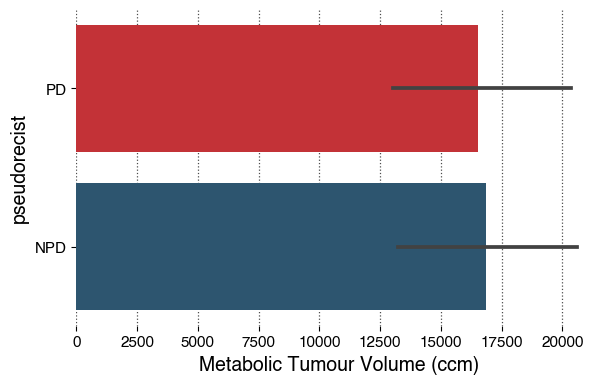

In [33]:
fig, ax = plt.subplots()

sns.barplot(data=organ, x='mtv', y='pseudorecist', ax=ax)

ax.set_xlabel('Metabolic Tumour Volume (ccm)')

In [24]:
organ = lesions[lesions.study_name.isin(['pre-01', 'post-01'])].groupby(['gpcr_id', 'study_name', 'assigned_organ']).mtv.mean().reset_index().merge(
    progression[['gpcr_id', 'study_name', 'pseudorecist']], on=['gpcr_id', 'study_name'], how='inner'
)

<AxesSubplot:xlabel='assigned_organ', ylabel='mtv'>

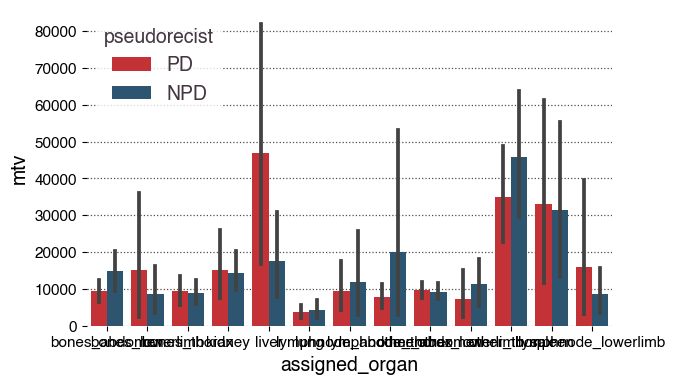

In [25]:
sns.barplot(data=organ, y='mtv', x='assigned_organ', hue='pseudorecist')

In [34]:
blood.columns

Index(['gpcr_id', 'n_days_to_treatment_start', 'n_days_to_treatment_end',
       'sex', 'bmi', 'has_brain_mets', 'performance_score_ecog',
       'eosini_absolus_gl', 'hemoglobine_sang_gl', 'gfr_cal_mlmin173m2',
       'potassium_sang_mmoll', 'asat_sang_ul', 'plaquettes_sang_gl',
       'pal_sang_ul', 'proteine_c_reacsang_mgl', 'mono_absolus_gl',
       'alat_sang_ul', 'bili_totale_sang_umoll', 'baso_absolus_gl',
       'ggt_sang_ul', 'leucocytes_sang_gl', 'neutro_absolus_gl',
       'creatinine_sang_umoll', 'lympho_absolus_gl', 'albumine_sang_gl',
       'ldh_sang_ul', 'calcium_sang_mmoll', 'eGFRCKD2', 'eGFRCG', 'X67',
       'NRAS_MUTATION', 'NRAS_MUT_TYPE', 'BRAF_MUTATION', 'BRAF_MUT_TYPE',
       'concomittant_tvec', 'concomittant_LAG3', 'prior_targeted_therapy',
       'prior_treatment', 'immuno_therapy_type', 'nivo_maintenance'],
      dtype='object')

In [64]:
from src.utils import load_dataset, preprocess, fetch_data
import networkx as nx

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx


plt.style.use('../assets/graphmel.mplstyle')

In [30]:
dataset_train, dataset_test = load_dataset(test_size=0, seed=12, dense=False, distance=1.0, suspicious=0.5)

In [44]:
graph = dataset_train[23]

In [50]:
X_train, _, _, _ = preprocess(*fetch_data(suspicious=0.5))

# list(enumerate(X_train.columns))

In [51]:
graph

Data(x=[9, 19], edge_index=[2, 48], y=[1], study_features=[9, 13], patient_features=[2], graph_sizes=[1], split_sizes=[1], aux_y=[9, 1], edge_weight=[48], num_nodes=9)

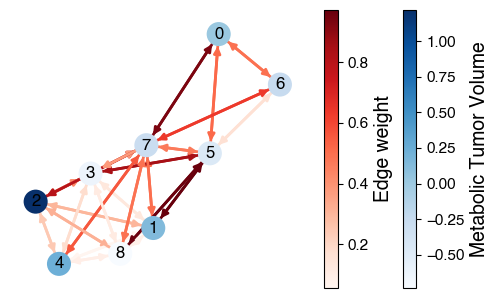

In [107]:
fig, ax = plt.subplots()

edge_cmap = plt.cm.Reds
edge_sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(min(graph.edge_weight), max(graph.edge_weight)))

node_cmap = plt.cm.Blues
node_sm = plt.cm.ScalarMappable(cmap=node_cmap, norm=plt.Normalize(graph.x[:, 2].min(), graph.x[:, 2].max()))

nx.draw_networkx(to_networkx(graph), width=2.0,
                 node_color=graph.x[:, 2], cmap=node_cmap,
                 edge_color=reordered_edge_weights, edge_cmap=edge_cmap,
                 ax=ax)

plt.colorbar(node_sm, label='Metabolic Tumor Volume')
plt.colorbar(edge_sm, label='Edge weight')

plt.tight_layout()

ax.grid(False)

#########
filename = '../report/figures/example_graph.png'

# Set accurate dimensions for LaTeX report
golden_ratio = (5 ** 0.5 - 1) / 2
latex_width = 5.0  # in inches
fig.set_size_inches(latex_width, latex_width * golden_ratio)

plt.savefig(filename, bbox_inches='tight')

In [100]:
i, j = graph.edge_index.numpy()

old_order = dict(zip(zip(i, j), graph.edge_weight.numpy()))

In [102]:
reordered_edge_weights = []

for e in to_networkx(graph).edges:
    reordered_edge_weights.append(old_order[e])
    
reordered_edge_weights

[0.515134,
 0.49528268,
 0.9300367,
 0.30051956,
 0.12912636,
 0.05645708,
 0.9711315,
 0.5007433,
 0.083531424,
 0.42316738,
 0.24521227,
 0.8012414,
 0.31627008,
 0.30051956,
 0.17849454,
 0.8490554,
 0.37866724,
 0.11229284,
 0.12912636,
 0.42316738,
 0.55713916,
 0.09356767,
 0.05645708,
 0.24521227,
 0.17849454,
 0.16376951,
 0.47038817,
 0.96134824,
 0.515134,
 0.9711315,
 0.8490554,
 0.6340466,
 0.49528268,
 0.16376951,
 0.49096006,
 0.9300367,
 0.5007433,
 0.8012414,
 0.37866724,
 0.55713916,
 0.47038817,
 0.6340466,
 0.083531424,
 0.31627008,
 0.11229284,
 0.09356767,
 0.96134824,
 0.49096006]

In [78]:
list(zip(list(to_networkx(graph).edges), graph.edge_weight.numpy()))

[((0, 5), 0.515134),
 ((0, 6), 0.49528268),
 ((0, 7), 0.9300367),
 ((1, 2), 0.30051956),
 ((1, 3), 0.12912636),
 ((1, 4), 0.05645708),
 ((1, 5), 0.9711315),
 ((1, 7), 0.5007433),
 ((1, 8), 0.083531424),
 ((2, 3), 0.42316738),
 ((2, 4), 0.24521227),
 ((2, 7), 0.8012414),
 ((2, 8), 0.31627008),
 ((2, 1), 0.17849454),
 ((3, 4), 0.8490554),
 ((3, 5), 0.37866724),
 ((3, 7), 0.11229284),
 ((3, 8), 0.55713916),
 ((3, 1), 0.09356767),
 ((3, 2), 0.16376951),
 ((4, 7), 0.47038817),
 ((4, 8), 0.96134824),
 ((4, 1), 0.6340466),
 ((4, 2), 0.49096006),
 ((4, 3), 0.515134),
 ((5, 6), 0.49528268),
 ((5, 7), 0.9300367),
 ((5, 8), 0.30051956),
 ((5, 0), 0.12912636),
 ((5, 1), 0.05645708),
 ((5, 3), 0.9711315),
 ((6, 7), 0.5007433),
 ((6, 0), 0.083531424),
 ((6, 5), 0.42316738),
 ((7, 8), 0.24521227),
 ((7, 0), 0.8012414),
 ((7, 1), 0.31627008),
 ((7, 2), 0.17849454),
 ((7, 3), 0.8490554),
 ((7, 4), 0.37866724),
 ((7, 5), 0.11229284),
 ((7, 6), 0.55713916),
 ((8, 1), 0.09356767),
 ((8, 2), 0.16376951),
 